In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [83]:
data = pd.read_csv('Code_challenge_train.csv')

In [3]:
data.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-17.933519,6.559220,2.422468,-27.737392,-12.080601,-3.892934,1.067466,0.935953,10.912007,1.107144,...,11.107047,0.093337,asia,0.421524,35.259947,8.994318,-21.000182,-0.686588,2.949106,1
1,-37.214754,10.774930,5.404072,21.354738,0.612690,-3.093533,6.161558,-0.972156,-5.222169,0.384969,...,-1.991846,15.666187,asia,-0.132764,-1.192563,3.885024,-37.886523,-7.730392,-1.107330,0
2,0.330441,-19.609972,-1.331804,-15.153892,19.710240,19.077300,-1.747110,0.545570,-1.464609,3.670570,...,17.132840,-5.333012,asia,1.432308,-3.435427,-1.133450,7.426099,-5.945534,1.316312,0


In [4]:
data.shape

(40000, 101)

In [5]:
# How many of the variables doesn't have missing values?
nulls = data.isnull().sum().to_frame()
nulls.loc[nulls[0] == 0,:] 

,0
y,0


In [6]:
# how many missing at most?
nulls[0].sort_values(ascending = False).head()

x55    16
x96    15
x21    15
x18    13
x63    13
Name: 0, dtype: int64

In [7]:
# percentage of missing values in the highest one
16 / data.shape[0] * 100 

0.04

In [8]:
# which variables are not numeric?
data.select_dtypes(include = 'object').head(3)

,x34,x35,x41,x45,x68,x93
0,bmw,thur,$-1306.52,-0.01%,sept.,asia
1,Toyota,wednesday,$-24.86,0.0%,July,asia
2,bmw,thurday,$-110.85,0.0%,July,asia


## Cleaning

Impute the nulls, in these object variables first

In [84]:
# 1. clean x41 and x45
data[['x41', 'x45']] = data[['x41', 'x45']].fillna('9999')

In [18]:
data[['x41', 'x45']].isnull().sum()

x41    0
x45    0
dtype: int64

In [85]:
# strip the $ and %
data['x41'] = data['x41'].map(lambda x: x.strip('$'))
data['x45'] = data['x45'].map(lambda x: x.strip('%'))

In [86]:
data[['x41', 'x45']] = data[['x41', 'x45']].astype('float')

In [34]:
# 2. how many different values in each of the object variables?
object_columns = data.select_dtypes(include='object').columns.to_list()

for n in object_columns:
    print(f"{n}: {data[n].value_counts().shape[0]}")

x34: 10
x35: 8
x68: 12
x93: 3


In [33]:
# x35 should be 7 of less values. 
data['x35'].value_counts(dropna = False)

wed          14829
thurday      13323
wednesday     5927
thur          4403
tuesday        898
friday         528
monday          59
fri             22
NaN             11
Name: x35, dtype: int64

In [87]:
# before we start cleaning that one up, we need to impute missing values. I'll fill them with 'unknown'
data[object_columns] = data[object_columns].fillna('unknown')

In [39]:
data['x35'].value_counts(dropna = False)

wed          14829
thurday      13323
wednesday     5927
thur          4403
tuesday        898
friday         528
monday          59
fri             22
unknown         11
Name: x35, dtype: int64

In [52]:
def weekdays(v):
    """
    This is a supporting function to cleaning(), to be used inside the latter. 
    Meant to be applied to each value of the weekdays variable.
    """
    if 'wed' in v:
        v = 'wednesday'
    elif 'thu' in v:
        v = 'thursday'
    elif 'fri' in v:
        v = 'friday'
        
    return v

In [88]:
data['x35'] = data['x35'].map(lambda x: weekdays(x))

In [101]:
# Combining all cleaning steps in a function
def cleaning(data):
    """
    This function is specific to 'Code_challenge_train.csv' and 'Code_challenge_test.csv'
    
    Parameters:
    -----------
    data: the data frame to clean. 
    """
    # numerical variables with strange characters and nulls: replace missing value with '9999'
    data[['x41', 'x45']] = data[['x41', 'x45']].fillna('9999')
    
    # strip the strange characters, and replace
    data['x41'] = data['x41'].map(lambda x: x.strip('$'))
    data['x45'] = data['x45'].map(lambda x: x.strip('%'))
    data[['x41', 'x45']] = data[['x41', 'x45']].astype('float')
    
    # filling nulls in rest of string variables with 'unknown'
    object_columns = data.select_dtypes(include='object').columns.to_list()
    data[object_columns] = data[object_columns].fillna('unknown')
    
    # weekdays variable is messy, cleaning it
    data['x35'] = data['x35'].map(lambda x: weekdays(x))
    
    # dropping 'x45'
    data.drop(['x45'], axis = 1, inplace = True)
    
    # changing months to numbers
    months_dict = {'January': 1, 'Feb': 2, 'Mar':3, 'Apr': 4, 'May': 5, 'Jun': 6, 'July': 7, 'Aug': 8, 'sept.': 9, 
                    'Oct': 10, 'Nov': 11, 'Dev': 12, 'unknown': 0}
    data['x68'] = data['x68'].map(months_dict)
    
    # one-hot encode the other string variables
    string_variables = data.select_dtypes(include='object').columns.to_list()
    string_dummies = pd.get_dummies(data[string_variables])
    data = pd.concat([data, string_dummies], axis = 1, sort = False)
    
    # dropping extra columns
    unknowns_columns = [n for n in data.columns if 'unknown' in n]
    data.drop(unknowns_columns, axis = 1, inplace = True)
    data.drop(['x34', 'x35', 'x93'], axis = 1, inplace = True)
    
    # filling missing values in the numerical variables
    numerical_columns = data.select_dtypes(exclude = 'object').columns.to_list()
    data[numerical_columns] = data[numerical_columns].fillna(method = 'bfill')
    
    return data

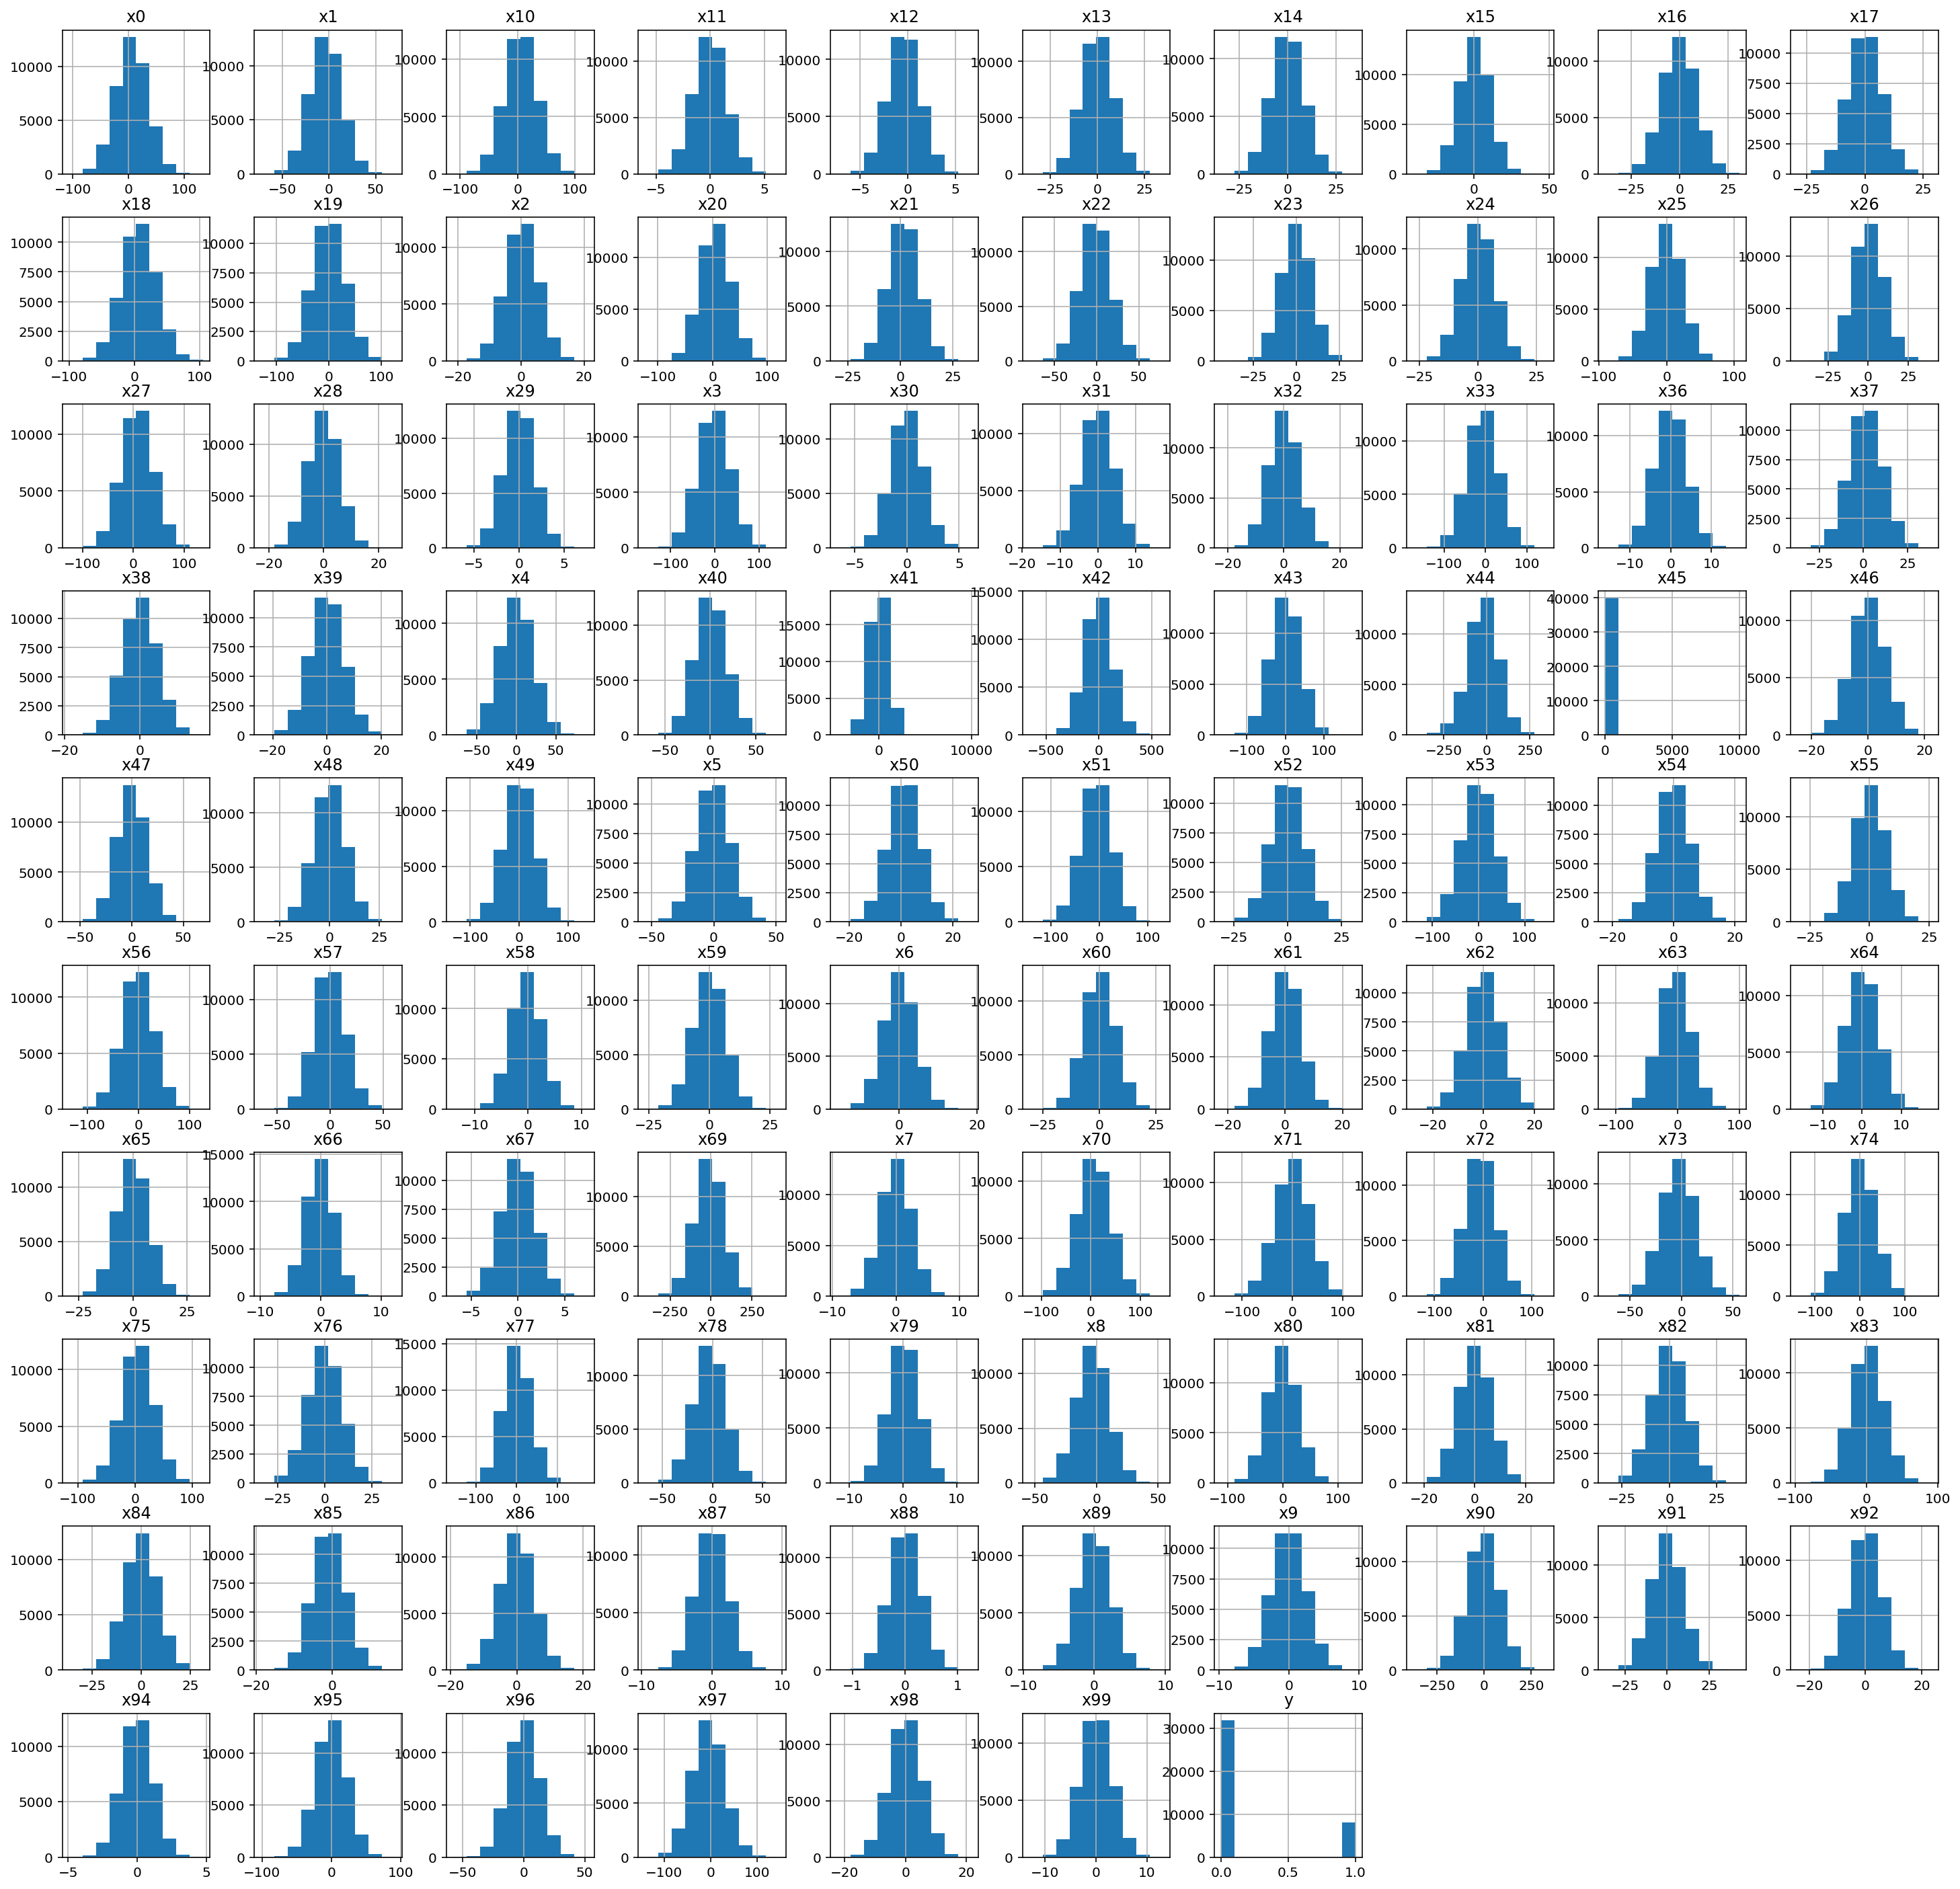

In [53]:
# we need to fill all missing values, 
# but first, let's see the distribution of these numerical variables, and if there's outliers
data.hist(figsize = (25, 25));

Observations: <br />
All the numerical variables are roughly normal. Except for 'x45', which is can be safely dropped. because it's almost the same always. Note: we imputed the nulls with 9999 so it's not really outliers that it has <br />
'x41' has a right outlier. 'x26', and 'x16' have moderate left outliers

In [57]:
data['x45'].value_counts()

 0.00       15524
 0.01        9577
-0.01        9569
 0.02        2390
-0.02        2374
-0.03         279
 0.03         257
-0.04          14
 0.04          11
 9999.00        5
Name: x45, dtype: int64

Before dropping the variable, let's double check that it doesn't have strong correlation with the target variable, as this would be explanatory.

In [64]:
data['x45'].corr(data['y'])

-9.146712948342792e-05

In [65]:
# ok, maybe there's no linear correlation, but how about its second degree?
data['x45'].map(lambda x: x ** 2).corr(data['y'])

-8.3392344943707e-05

We're good to drop it

In [89]:
data.drop(['x45'], axis = 1, inplace = True)

Imputing missing values from the rest of the numerical variables: <br />
since there isn't many missing values, imputing them won't affect results badly. <br />
We have at most 16 missing values, and they are spread out well enough to fill the missing values with 'bfill' or 'pad' rather than 'interpolate' which we can also do. <br />
The code used to check these values is: 
```
import numpy as np
for n in data.select_dtypes(exclude = 'object').columns.to_list():
    print(n)
    print(np.nonzero(pd.isnull(data[n])))
    print('---------')
```
I didn't want to clutter the notebook, so I ran it and deleted the cell.

In [100]:
numerical_columns = data.select_dtypes(exclude = 'object').columns.to_list()
data[numerical_columns] = data[numerical_columns].fillna(method = 'bfill')

***
**Now to change the categorical variables to numericals**

In [132]:
# recall that x68 was the months. Let's take care of that first
months_dict = {'January': 1, 'Feb': 2, 'Mar':3, 'Apr': 4, 'May': 5, 'Jun': 6, 'July': 7, 'Aug': 8, 'sept.': 9, 
'Oct': 10, 'Nov': 11, 'Dev': 12, 'unknown': 0}

data['x68'] = data['x68'].map(months_dict)

In [135]:
string_variables = data.select_dtypes(include='object').columns.to_list()
string_dummies = pd.get_dummies(data[string_variables])
data = pd.concat([data, string_dummies], axis = 1, sort = False)

In [140]:
unknowns_columns = [n for n in data.columns if 'unknown' in n]
data.drop(unknowns_columns, axis = 1, inplace = True)
# no information is lost here. 

Alternatively, we could've one-hot encode the string variables first, including the nulls, then drop the null columns

In [141]:
data.shape

(40000, 118)

In [102]:
# double checking one final time that we don't have any nulls
nulls = data.isnull().sum().to_frame()
nulls.loc[nulls[0] != 0, :]

,0
